In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
import os
from collections import Counter

from keras.layers import merge, Input
from keras.layers.core import Activation
from keras.layers.convolutional import Conv2D, Cropping2D,Conv2DTranspose
from keras.layers import Add
from keras.models import Model
from keras.optimizers import Adam
from keras.engine.topology import Layer
from keras.utils import np_utils, generic_utils
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.initializers import Constant
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(seed=32)

# model

In [54]:
class FullyConvolutionalNetwork():
    def __init__(self, batchsize=1, img_height=512, img_width=512, FCN_CLASSES=5):
        self.batchsize = batchsize
        self.img_height = img_height
        self.img_width = img_width
        self.FCN_CLASSES = FCN_CLASSES
        self.vgg16 = VGG16(include_top=False,
                           weights='imagenet',
                           input_tensor=None,
                           input_shape=(self.img_height, self.img_width,3))

    def create_fcn32s(self):
        ip = Input(shape=(self.img_height, self.img_width,3))
        h = self.vgg16.layers[1](ip)
        h = self.vgg16.layers[2](h)
        h = self.vgg16.layers[3](h)
        h = self.vgg16.layers[4](h)
        h = self.vgg16.layers[5](h)
        h = self.vgg16.layers[6](h)
        h = self.vgg16.layers[7](h)
        h = self.vgg16.layers[8](h)
        h = self.vgg16.layers[9](h)
        h = self.vgg16.layers[10](h)

        h = self.vgg16.layers[11](h)
        h = self.vgg16.layers[12](h)
        h = self.vgg16.layers[13](h)
        h = self.vgg16.layers[14](h)

        h = self.vgg16.layers[15](h)
        h = self.vgg16.layers[16](h)
        h = self.vgg16.layers[17](h)
        h = self.vgg16.layers[18](h)

        h = Conv2D(self.FCN_CLASSES, (1, 1), activation='relu')(h)
        h = Conv2DTranspose(self.FCN_CLASSES,(64,64), strides=(32,32),padding="same",kernel_initializer=Constant(bilinear_upsample_weights(32,self.FCN_CLASSES)))(h)
        
        op = Activation('softmax')(h)
        model = Model(ip, op)
        for layer in model.layers[:15]:
            layer.trainable = False
        return model
    
    def create_fcn8s(self, train_flag=True):
            #(samples, channels, rows, cols)
            ip = Input(shape=(self.img_height, self.img_width,3))
            h = self.vgg16.layers[1](ip)
            h = self.vgg16.layers[2](h)
            h = self.vgg16.layers[3](h)
            h = self.vgg16.layers[4](h)
            h = self.vgg16.layers[5](h)
            h = self.vgg16.layers[6](h)
            h = self.vgg16.layers[7](h)
            h = self.vgg16.layers[8](h)
            h = self.vgg16.layers[9](h)
            h = self.vgg16.layers[10](h)

            # split layer
            p3 = h

            h = self.vgg16.layers[11](h)
            h = self.vgg16.layers[12](h)
            h = self.vgg16.layers[13](h)
            h = self.vgg16.layers[14](h)

            # split layer
            p4 = h

            h = self.vgg16.layers[15](h)
            h = self.vgg16.layers[16](h)
            h = self.vgg16.layers[17](h)
            h = self.vgg16.layers[18](h)

            p5 = h

            p5 = Conv2D(self.FCN_CLASSES, (1, 1), activation='relu')(p5)
            p4 = Conv2D(self.FCN_CLASSES, (1, 1), activation='relu')(p4)
            p3 = Conv2D(self.FCN_CLASSES, (1, 1), activation='relu')(p3)

            p4  = Conv2DTranspose(self.FCN_CLASSES,(4,4), strides=(2,2),padding="same", kernel_initializer=Constant(bilinear_upsample_weights(2,self.FCN_CLASSES)))(p4)
            p5  = Conv2DTranspose(self.FCN_CLASSES,(8,8), strides=(4,4),padding="same", kernel_initializer=Constant(bilinear_upsample_weights(4,self.FCN_CLASSES)))(p5)
            h = Add()([p4,p5,p3])
            h = Conv2DTranspose(self.FCN_CLASSES,(16,16), strides=(8,8),padding="same",kernel_initializer=Constant(bilinear_upsample_weights(8,self.FCN_CLASSES)))(h)
            op = Activation('softmax')(h)
            model = Model(ip,op)
            for layer in model.layers[:15]:
                layer.trainable = False
            return model


def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:filter_size, :filter_size]
    upsample_kernel = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

In [55]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense,Reshape, Input,merge
from keras.layers.merge import concatenate
from keras.layers.core import Activation, Dropout, Flatten,Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D,Conv2D, MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU

# convolution batchnormalization relu
def CBR(ch,shape,bn=True,sample='down',activation=LeakyReLU, dropout=False):
    model = Sequential()
    if sample=='down':
        model.add(Conv2D(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    else:
        model.add(Conv2DTranspose(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape, kernel_initializer=Constant(bilinear_upsample_weights(2,ch))))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    if activation == LeakyReLU:
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation('relu'))
    return model

def generator(nb_classes):

    # encoder
    input = Input(shape=(512,512,3))#２の階上（）
    enc_1 = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same',input_shape=(512,512,3))(input)

    enc_2 = CBR(64,(512,512,32))(enc_1)
    enc_3 = CBR(128,(256,256,64))(enc_2)
    enc_4 = CBR(256,(128,128,128))(enc_3)
    enc_5 = CBR(512,(64,64,256))(enc_4)
    enc_6 = CBR(512,(32,32,512))(enc_5)
    enc_7 = CBR(512,(16,16,512))(enc_6)
    enc_8 = CBR(512,(8,8,512))(enc_7)

    # decoder
    x = CBR(512,(4,4,512),sample='up',activation='relu',dropout=True)(enc_8)
    x = CBR(512,(8,8,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_7]))
    x = CBR(512,(16,16,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_6]))
    x = CBR(256,(32,32,1024),sample='up',activation='relu',dropout=False)(concatenate([x,enc_5]))
    x = CBR(128,(64,64,512),sample='up',activation='relu',dropout=False)(concatenate([x,enc_4]))
    x = CBR(64,(128,128,256),sample='up',activation='relu',dropout=False)(concatenate([x,enc_3]))
    x = CBR(32,(256,256,128),sample='up',activation='relu',dropout=False)(concatenate([x,enc_2]))
    x = Conv2D(filters=nb_classes, kernel_size=(3,3),strides=1,padding="same")(concatenate([x,enc_1]))
    output = Activation('softmax')(x)
    
    model = Model(inputs=input, outputs=output)
    return model

# training

In [148]:
def binarylab(labels, size, nb_class):
    y = np.zeros((size,size,nb_class))
    for i in range(size):
        for j in range(size):
            y[i,j,labels[i][j]] = 1
    return y

def load_data(path, size=512, mode=None):
    img = Image.open(path)
    w,h = img.size
    lw = np.random.randint(0,(w-size)/2)
    lh = np.random.randint(0,(h-size)/2)
    img = img.crop((lw,lh, lw+size, lh +size))
    if mode == "original":
        return img
    if mode == "label":
        y = np.array(img, dtype=np.int32)
        y = binarylab(y,size, 5)
        y = np.expand_dims(y, axis=0)
        return y
    if mode == "data":
        X = image.img_to_array(img)
        X = np.expand_dims(X,axis=0)
        X = preprocess_input(X)
        return X
    
def generate_arrays_from_file(names, path_to_train, path_to_target, img_size, nb_class):
    while True:
        for name in names:
            Xpath = path_to_train + "or{}.png".format(name)
            ypath = path_to_target + "col{}.png".format(name)
            X = load_data(Xpath, img_size, mode="data")
            y = load_data(ypath, img_size, mode = "label")
            yield(X,y)
            
def load_data_aug(path, size=512, mode=None):
    data_list = []
    img = Image.open(path)
    w,h = img.size
    lw = np.random.randint(0,(w-size)/2)
    lh = np.random.randint(0,(h-size)/2)
    for i in range(1):
        img = img.crop((lw,lh, lw+size, lh +size))
        if i == 1:
            img = ImageOps.flip(img)
        elif i == 2:
            img = ImageOps.mirror(img)
        if mode == "original":
            data_list.append(img)
        if mode == "label":
            y = np.array(img, dtype=np.int32)
            y = binarylab(y,size, 5)
            # y = np.expand_dims(y, axis=0)
            data_list.append(y)
        if mode == "data":
            X = image.img_to_array(img)
            # X = np.expand_dims(X,axis=0)
            X = preprocess_input(X)
            data_list.append(X)
    data = np.array(data_list)
    if mode == "data":
        data = preprocess_input(data)
    return data

def generate_arrays_from_file(names, path_to_train, path_to_target, img_size, nb_class):
    while True:
        for name in names:
            Xpath = path_to_train + "or{}.png".format(name)
            ypath = path_to_target + "col{}.png".format(name)
            X = load_data(Xpath, img_size, mode="data")
            y = load_data(ypath, img_size, mode = "label")
            yield(X,y)


def generate_dataset(names, path_to_train, path_to_target, img_size, nb_class):
    X_list = []
    y_list = []
    for name in names:
        Xpath = path_to_train + "or{}.png".format(name)
        ypath = path_to_target + "col{}.png".format(name)
        X = load_data_aug(Xpath, img_size, mode="data")
        y = load_data_aug(ypath, img_size, mode = "label")
        X_list.append(X)
        y_list.append(y)
    return np.array(X_list).reshape([-1,img_size, img_size, 3]), np.array(y_list).reshape([-1, img_size, img_size, 5])


In [149]:
import numpy as np

def get_bit(byte_val, idx):
    return int((byte_val & (1 << idx)) != 0)

def shift_bit(byte_val, idx):
    return byte_val << idx if idx >= 0 else byte_val >> (-idx)

def bitor(a, b):
    return a | b

def make_color_map():
    n = 256
    cmap = np.zeros((n, 3)).astype(np.int32)
    for i in range(0, n):
        d = i - 1
        r,g,b = 0,0,0
        for j in range(0, 7):
            r = bitor(r, shift_bit(get_bit(d, 0), 7 - j))
            g = bitor(g, shift_bit(get_bit(d, 1), 7 - j))
            b = bitor(b, shift_bit(get_bit(d, 2), 7 - j))
            d = shift_bit(d, -3)
        cmap[i, 0] = b
        cmap[i, 1] = g
        cmap[i, 2] = r
    return cmap[1:22]


In [150]:
path_to_train    = "./data/ori/"
path_to_target = "./data/label/"
img_size = 512
nb_classes = 5
names = os.listdir('data/ori/')
names = np.array([name[2:7] for name in names])
ind = np.random.permutation(len(names))
train_names = names[ind[:int(len(names) * 0.8)]]
test_names  = names[ind[int(len(names) * 0.8):]]
nb_data = len(train_names)

In [151]:
def crossentropy(y_true, y_pred):
    return K.mean(-K.sum(y_true*K.log(y_pred + 1e-7),axis=[3]),axis=[1,2])

train_X, train_y = generate_dataset(train_names, path_to_train, path_to_target, img_size, nb_classes)

FCN = FullyConvolutionalNetwork(img_height=img_size, img_width=img_size,FCN_CLASSES=nb_classes)
adam = Adam(1e-5) 
train_model = FCN.create_fcn32s()
# train_model = FCN.create_fcn8s()
# train_model = generator(nb_classes)
train_model.compile(loss=crossentropy, optimizer=adam)

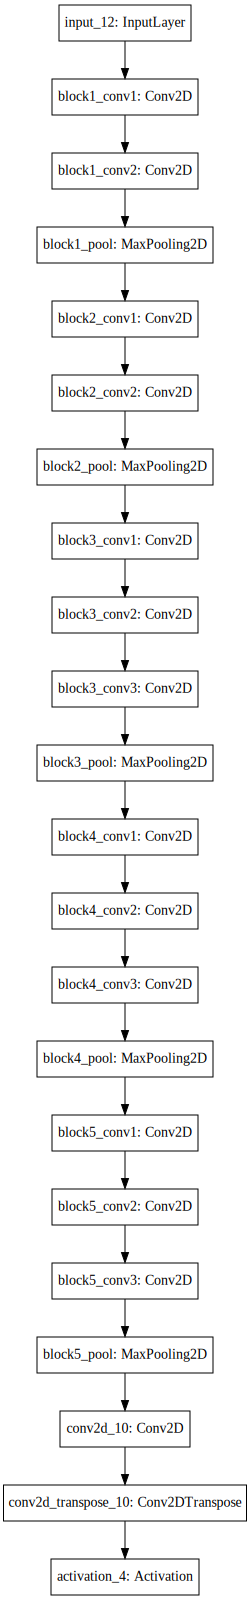

In [32]:
# SVG(model_to_dot(train_model).create(prog='dot', format='svg'))

In [155]:
# train_model.fit_generator(generate_arrays_from_file(train_names, path_to_train, path_to_target, img_size, nb_classes),
#                                                steps_per_epoch=nb_data/1, epochs=100)
train_model.fit(train_X, train_y, batch_size=1, epochs=100)

# train_model.save_weights('weights.h5')

Epoch 1/100
28/28 [==============================] - 1s - loss: 0.1519     
Epoch 2/100
28/28 [==============================] - 1s - loss: 0.1516     
Epoch 3/100
28/28 [==============================] - 1s - loss: 0.1550     
Epoch 4/100
28/28 [==============================] - 1s - loss: 0.1573     
Epoch 5/100
28/28 [==============================] - 1s - loss: 0.1557     
Epoch 6/100
28/28 [==============================] - 1s - loss: 0.1544     
Epoch 7/100
28/28 [==============================] - 1s - loss: 0.1544     
Epoch 8/100
28/28 [==============================] - 1s - loss: 0.1523     
Epoch 9/100
28/28 [==============================] - 1s - loss: 0.1545     
Epoch 10/100
28/28 [==============================] - 1s - loss: 0.1585     
Epoch 11/100
28/28 [==============================] - 1s - loss: 0.1563     
Epoch 12/100
28/28 [==============================] - 1s - loss: 0.1535     
Epoch 13/100
28/28 [==============================] - 1s - loss: 0.1534     
Epoch 14

In [140]:
# 訓練済みweightを使う場合
trained_model = FCN.create_fcn32s()
trained_model.load_weights('weights.h5')

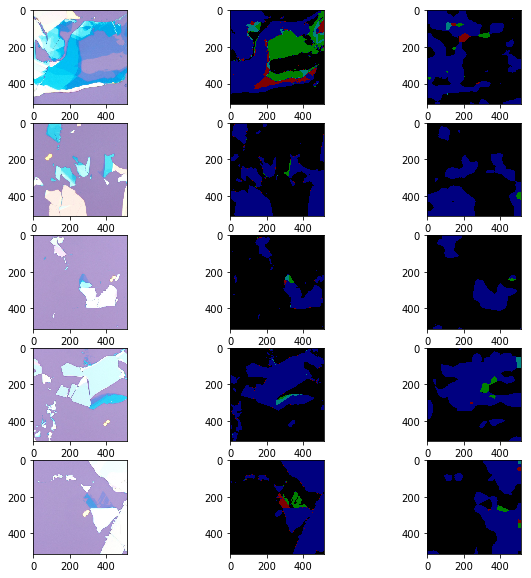

In [153]:
# training data
plt.figure(figsize=(10,10))
color_map = make_color_map()
ind = np.random.permutation(nb_data)[0:5]
for r,i in enumerate(ind):
    img = load_data(path_to_train    + 'or' + train_names[i] + '.png',  img_size, 'original')
    x     = load_data(path_to_train    + 'or' + train_names[i] + '.png',  img_size, 'data')
    y     = load_data(path_to_target + 'col' + train_names[i] + '.png', img_size, 'label')
    pred = train_model.predict(x)[0].argmax(axis=2)
    y = y[0].argmax(axis=2)
    y_rgb = np.zeros((img_size,img_size,3))
    pred_rgb = np.zeros((img_size, img_size,3))
    for i in range(nb_classes):
        y_rgb[y == i] = color_map[i]
        pred_rgb[pred==i] = color_map[i]
    plt.subplot(5,3, 3*r+ 1)
    plt.imshow(img)
    plt.subplot(5,3, 3*r + 2)
    plt.imshow(y_rgb)
    plt.subplot(5,3, 3*r + 3)
    plt.imshow(pred_rgb)

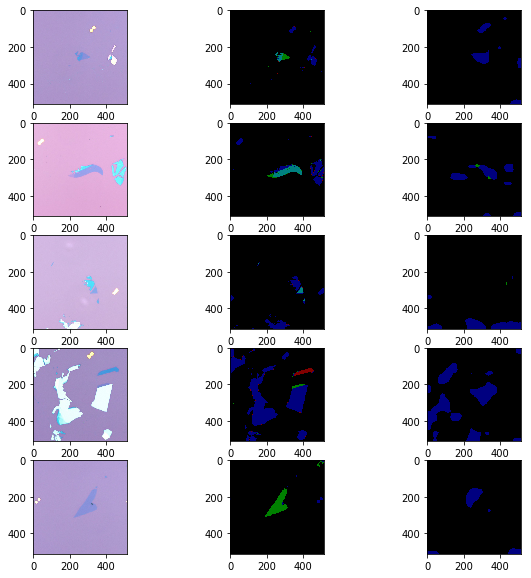

In [154]:
# test data
plt.figure(figsize=(10,10))
nb_test = len(test_names)
ind = np.random.permutation(nb_test)[0:5]
for r,i in enumerate(ind):
    img = load_data(path_to_train    + 'or' + test_names[i] + '.png',  img_size, 'original')
    x     = load_data(path_to_train    + 'or' + test_names[i] + '.png',  img_size, 'data')
    y     = load_data(path_to_target + 'col' + test_names[i] + '.png', img_size, 'label')
    pred = train_model.predict(x)[0].argmax(axis=2)
    y = y[0].argmax(axis=2)
    y_rgb = np.zeros((img_size,img_size,3))
    pred_rgb = np.zeros((img_size, img_size,3))
    for i in range(nb_classes):
        y_rgb[y == i] = color_map[i]
        pred_rgb[pred==i] = color_map[i]
    plt.subplot(5,3, 3*r + 1)
    plt.imshow(img)
    plt.subplot(5,3, 3*r + 2)
    plt.imshow(y_rgb)
    plt.subplot(5,3, 3*r + 3)
    plt.imshow(pred_rgb)
plt.savefig('predict.png')

In [132]:
# 精度を計算
nb_test = len(test_names)
acc_list = []
tf = np.zeros([5,5])
for name in test_names:
    i = np.random.randint(0,high=nb_test)
    img = load_data(path_to_train    + 'or' + name + '.png',  img_size, 'original')
    x     = load_data(path_to_train    + 'or' + name + '.png',  img_size, 'data')
    y     = load_data(path_to_target + 'col' + name + '.png', img_size, 'label')
    pred = train_model.predict(x)[0].argmax(axis=2)
    y = y[0].argmax(axis=2)
    acc_list.append(np.sum(y == pred) / (512 * 512))
    for i in range(img_size):
        for j in range(img_size):
            tf[y[i,j], pred[i,j]] += 1

print(np.mean(acc_list))

0.775022779192


In [135]:
import pandas as pd
pd.DataFrame(tf)

,0,1,2,3,4
0,1311874.0,129769.0,254.0,378.0,1228.0
1,183005.0,110095.0,1712.0,2060.0,1319.0
2,46437.0,3963.0,194.0,1130.0,14.0
3,15561.0,6526.0,1.0,2.0,2.0
4,15912.0,3510.0,14.0,40.0,8.0


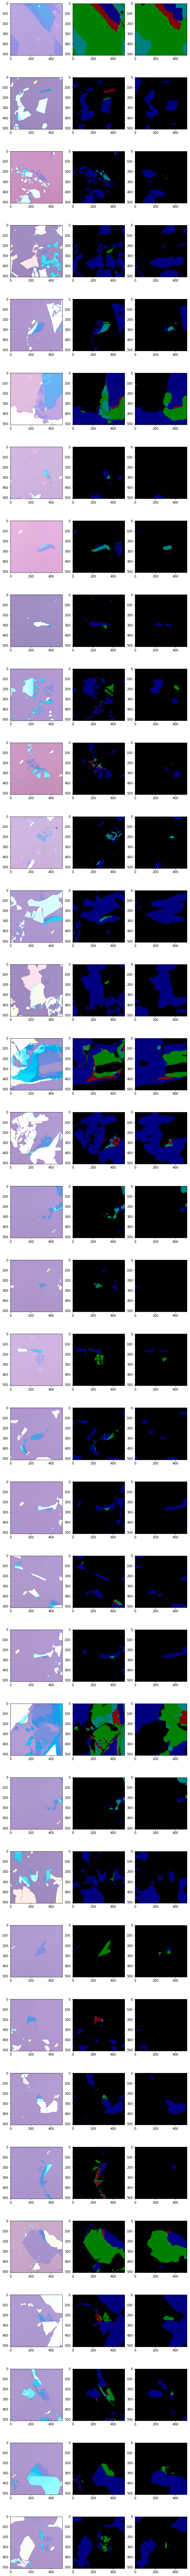

In [147]:
# test data
plt.figure(figsize=(10,150))
nb_test = len(names)
ind = np.random.permutation(nb_test)
for r,i in enumerate(ind):
    img = load_data(path_to_train    + 'or'  + names[i] + '.png',  img_size, 'original')
    x     = load_data(path_to_train    + 'or'  + names[i] + '.png',  img_size, 'data')
    y     = load_data(path_to_target + 'col' + names[i] + '.png', img_size, 'label')
    pred = trained_model.predict(x)[0].argmax(axis=2)
    y = y[0].argmax(axis=2)
    y_rgb = np.zeros((img_size,img_size,3))
    pred_rgb = np.zeros((img_size, img_size,3))
    for i in range(nb_classes):
        y_rgb[y == i] = color_map[i]
        pred_rgb[pred==i] = color_map[i]
    plt.subplot(len(names),3, 3*r + 1)
    plt.imshow(img)
    plt.subplot(len(names),3, 3*r + 2)
    plt.imshow(y_rgb)
    plt.subplot(len(names),3, 3*r + 3)
    plt.imshow(pred_rgb)
# plt.savefig('predict.png')

# 課題
- data augmentation(回転), epochごとに変えない
- 2値分類
- Unetモデル